<a href="https://colab.research.google.com/github/3wweiweiwu/ShiftAI/blob/master/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !git clone --recursive https://github.com/Microsoft/LightGBM
# %cd /content/LightGBM
# !mkdir build
# !cmake -DUSE_GPU=1
# !make -j$(nproc)
# !sudo apt-get -y install python-pip
# !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
# %cd /content/LightGBM/python-package
# !sudo python setup.py install --precompile

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import re, string,pickle
from scipy import sparse
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score,mean_absolute_error,median_absolute_error

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from abc import ABC, abstractmethod,abstractproperty,abstractstaticmethod

class COLUMN_Interface(object):
    __metaclass__ = ABCMeta

    @classmethod
    def version(self): return "1.0"
    
    @classmethod
    def Validate_Column_Name(self,df):
      if self.column_name not in df.columns:
        raise Exception('Cannot find column name '+self.column_name+' from '+df.columns)
    @abstractproperty
    def Prosess(self,df):
      raise NotImplementedError
      
    def _Treat_NA(self,df):
      raise NotImplementedError
        
    @abstractproperty
    @abstractmethod
    def na_treatment_list():
        raise NotImplementedError        
        
    @abstractmethod
    def __init__(self, COLUMN_NAME, COLUMN_DATA_TYPE,NA_TREATMENT_TYPE):
        if(NA_TREATMENT_TYPE not in self.na_treatment_list):
          raise Exception('Unknown NA Treatment '+NA_TREATMENT_TYPE+' for coulmn')
        self.column_data_type = COLUMN_DATA_TYPE
        self.na_treatment_type = NA_TREATMENT_TYPE
        self.column_name=COLUMN_NAME
      
    


In [0]:
class TextColumn(COLUMN_Interface):

  
  NA_REMOVE = 'Remoe'
  NA_EMPTY = 'EMPTY'
  na_treatment_list=[NA_REMOVE,NA_EMPTY]
  def Process(self,df):
    self.Validate_Column_Name(df) 
    pass
  def _Remove_Na_Row(df):
    df=df.dropna(axis=0,subset=[self.column_name])
  def _Fill_Na_With_Empty(df):
    df[[self.column_name]]=df[[self.column_name]].fillna(value='')
  
  def _Treat_NA(self,df):
    methods = {NA_REMOVE:_Remove_Na_Row,NA_EMPTY:_Fill_Na_With_Empty}
    pass

SyntaxError: ignored

In [0]:
s1='hello'
s2={s1:'world'}
s2

{'hello': 'world'}

In [0]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


def text_to_wordlist(text, remove_stopwords=False, stem_words=False, remove_num=False,remove_spec_cha=False):
    # Clean the text, with the option to remove stopwords and to stem words.

    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    if remove_num:
      replace_numbers=re.compile(r'\d+',re.IGNORECASE)
      text=replace_numbers.sub('n',text)
    
    if remove_spec_cha:
        special_chacter_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
        text=special_chacter_removal.sub(' ',text)    


    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)


def updateDf(df,enc_severity,enc_DefectType,isProductSpecific=False):
    #examine the data and ensure everything is correct
    df['Area Path']=df['Area Path'].astype('str')
    df['Title']=df['Title'].astype('str')
    df['Defect Type']=df['Defect Type']=df['Defect Type'].astype('str').str.lower()

    df['Submitted Date']=df['Submitted Date'].astype('str').apply(lambda str:str[0:24])
    df['Submitted Date']=pd.to_datetime(df['Submitted Date'])
    df['Submitter']=df['Submitter'].astype('str')
    df['Defect Priority']=df['Defect Priority'].astype('str')
    df['Defect Severity']=df['Defect Severity'].astype('str')
    df['Repro Steps']=df['Repro Steps'].astype('str')
    
    #get rid of data without severity info as they are useless
    df=df[df['Defect Severity']!='nan']
    df=df[df['Defect Severity']!='To be set at Review']
    
    #encode the severity
    df['icat']=enc_severity.transform(df['Defect Severity'].values.reshape(-1,1))
    
    
    #encode the defect type

    df['iDefectType']=enc_DefectType.transform(df['Defect Type'].values.reshape(-1,1))
    
    #these 2 fields are for family specific tunning. Comment out these for right now
    if(isProductSpecific):
        df['iSubmitter']=df['Submitter'].astype('category').cat.codes
        df['iarea']=df['Area Path'].astype('category').cat.codes
        df['iPriority']=df['Defect Priority'].astype('category').cat.codes
        df['iAssigned']=df['Assigned To'].astype('category').cat.codes
        
    
    
    
    #get rid of scopus defect as they are too noisy
    df=df[~df['Repro Steps'].str.contains('Scopus_Incident')]



    #use regular expression to get rid of ==== State: Submitted by: Stella_Zhao on 29 December 2015 04:02:58 ==== pattern

    pattern=r"==== State.*?===="
    df['Repro Steps']=df['Repro Steps'].astype('str').apply(lambda str:re.sub(pattern,'',str))

    #use beautiful soap to get rid of html tags

    df['Repro Steps']=df['Repro Steps'].astype('str').apply(lambda str:BeautifulSoup(str, "lxml").text)
    df['Repro Steps']=df['Repro Steps'].astype('str').apply(lambda str:text_to_wordlist(str,True,True,True,True))
    df['Title']=df['Title'].astype('str').apply(lambda str:text_to_wordlist(str,True,True,True,True))

    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


def text_to_wordlist(text, remove_stopwords=False, stem_words=False, remove_num=False,remove_spec_cha=False):
    # Clean the text, with the option to remove stopwords and to stem words.

    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    if remove_num:
      replace_numbers=re.compile(r'\d+',re.IGNORECASE)
      text=replace_numbers.sub('n',text)
    
    if remove_spec_cha:
        special_chacter_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
        text=special_chacter_removal.sub(' ',text)    


    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)


def updateDf(df,enc_severity,enc_DefectType,isProductSpecific=False):
    #examine the data and ensure everything is correct
    df['Area Path']=df['Area Path'].astype('str')
    df['Title']=df['Title'].astype('str')
    df['Defect Type']=df['Defect Type']=df['Defect Type'].astype('str').str.lower()

    df['Submitted Date']=df['Submitted Date'].astype('str').apply(lambda str:str[0:24])
    df['Submitted Date']=pd.to_datetime(df['Submitted Date'])
    df['Submitter']=df['Submitter'].astype('str')
    df['Defect Priority']=df['Defect Priority'].astype('str')
    df['Defect Severity']=df['Defect Severity'].astype('str')
    df['Repro Steps']=df['Repro Steps'].astype('str')
    
    #get rid of data without severity info as they are useless
    df=df[df['Defect Severity']!='nan']
    df=df[df['Defect Severity']!='To be set at Review']
    
    #encode the severity
    df['icat']=enc_severity.transform(df['Defect Severity'].values.reshape(-1,1))
    
    
    #encode the defect type

    df['iDefectType']=enc_DefectType.transform(df['Defect Type'].values.reshape(-1,1))
    
    #these 2 fields are for family specific tunning. Comment out these for right now
    if(isProductSpecific):
        df['iSubmitter']=df['Submitter'].astype('category').cat.codes
        df['iarea']=df['Area Path'].astype('category').cat.codes
        df['iPriority']=df['Defect Priority'].astype('category').cat.codes
        df['iAssigned']=df['Assigned To'].astype('category').cat.codes
        
    
    
    
    #get rid of scopus defect as they are too noisy
    df=df[~df['Repro Steps'].str.contains('Scopus_Incident')]



    #use regular expression to get rid of ==== State: Submitted by: Stella_Zhao on 29 December 2015 04:02:58 ==== pattern

    pattern=r"==== State.*?===="
    df['Repro Steps']=df['Repro Steps'].astype('str').apply(lambda str:re.sub(pattern,'',str))

    #use beautiful soap to get rid of html tags

    df['Repro Steps']=df['Repro Steps'].astype('str').apply(lambda str:BeautifulSoup(str, "lxml").text)
    df['Repro Steps']=df['Repro Steps'].astype('str').apply(lambda str:text_to_wordlist(str,True,True,True,True))
    df['Title']=df['Title'].astype('str').apply(lambda str:text_to_wordlist(str,True,True,True,True))

    return df

In [0]:
import re,string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
class NB:
    def __init__(self):
        self.r=None
        re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
        def tokenize(s): return re_tok.sub(r' \1 ', s).split()            
        self.vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                smooth_idf=1, sublinear_tf=1 )
    def _pr(self,y_i, y,x):
        p = x[y==y_i].sum(0)
        return (p+1) / ((y==y_i).sum()+1)
    def _compute_r(self,trn_term_doc,y_train):
        return np.log(self._pr(1,y_train,trn_term_doc) / self._pr(0,y_train,trn_term_doc))
    def fit_transform(self,trn_term_doc,y_train):        
        trn_term_doc=self.vec.fit_transform(trn_term_doc)
        self.r=self._compute_r(trn_term_doc,y_train)
        trn_term_doc=trn_term_doc.multiply(self.r)
        return trn_term_doc
    def transform(self,test_term_doc):
        test_term_doc=self.vec.transform(test_term_doc)        
        return test_term_doc.multiply(self.r)
    

    
        

In [0]:
from sklearn import preprocessing
import numpy as np
class Encoder:
    @staticmethod
    def SeverityEncoder():
        enc_severity = preprocessing.OrdinalEncoder()
        enc_severity.fit(np.array(['S3-Medium', 'S4-Minor', 'S2-Major', 'S1-Critical','S5-Insignificant']).reshape(-1, 1))
        return enc_severity
    @staticmethod
    def DefectTypeEncoder():
        enc_DefectType = preprocessing.OrdinalEncoder()
        problemTypes=['Incorrect Algorithm', 'Does Not Work As Designed', 'Data Loss',
            'Cosmetic', 'Crash/Freeze', 'Poor Performance', 'Integration',
            'Functionality Loss', 'Internationalization', 'Data Corruption',
            'Question', 'Documentation', 'Enhancement', 'internationalization',
            'UX', 'Inspection', 'Security', 'Installation','nan']
        problemTypes=[item.lower() for item in problemTypes]
        enc_DefectType.fit(np.array(problemTypes).reshape(-1, 1))        
        return enc_DefectType
    @staticmethod
    def DefectPriorityEncoder():
        enc_DefectType = preprocessing.OrdinalEncoder()
        enc_DefectType.fit(np.array(['3-High', '2-Critical', '4-Medium', '5-Low', '1-Show Stopper','nan']).reshape(-1, 1))        
        return enc_DefectType

In [0]:
dataPath='./gdrive/My Drive/data'
glovePath='./gdrive/My Drive/glove'
EMBEDDING_FILE=f'{glovePath}/glove.6B.300d.txt'
# DATA_FILE=f'{dataPath}/HYSYS Defect Priority Query.csv'
DATA_FILE=f'{dataPath}/Aspen Plus Defect Priority Query.csv'
# DATA_FILE=f'{dataPath}/APM Defect Priority Query.csv'
# DATA_FILE=f'{dataPath}/MES.csv'
# DATA_FILE=f'{dataPath}/AES.csv'
MODEL_PATH='./gdrive/My Drive/Model'

In [0]:
df=pd.read_csv(DATA_FILE)

Category=Encoder

df=updateDf(df,Category.SeverityEncoder(),Category.DefectTypeEncoder(),True)
X_train, X_test, y_train, y_test = train_test_split(df, df['icat'], test_size=0.33, random_state=42)


In [0]:

target='iPriority'
if(target=='Estimate'):
  df=df[df['Estimate']<=4]
  df=df[df['Estimate']>0]
df=df[df[target]!=-1]
X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size=0.33, random_state=42)
nb_Trans=NB()


#convert test procedure into step
trn_term_doc = nb_Trans.fit_transform(X_train['Repro Steps'],y_train.values)
test_term_doc=nb_Trans.transform(X_test['Repro Steps'])

In [0]:
#convert subject data into step
nb_title=NB()
train_subject=nb_title.fit_transform(X_train['Title'],y_train.values)
test_subject=nb_title.transform(X_test['Title'])


In [0]:
repro_labels=['repro-'+item for item in nb_Trans.vec.get_feature_names()]
title_labels=['title-'+item for item in nb_title.vec.get_feature_names()]

In [0]:
categoryData_Train=np.array(X_train['iDefectType']).reshape(len(X_train['iDefectType']),1)

categoryDataMatrix_Train=sparse.csr_matrix(categoryData_Train)

categoryData_Test=np.array(X_test['iDefectType']).reshape(len(X_test['iDefectType']),1)
categoryDataMatrix_Test=sparse.csr_matrix(categoryData_Test)

In [0]:
categoryLabels=['iarea','iDefectType','iSubmitter']
categoryData_Train=X_train[categoryLabels].astype('float').values
categoryDataMatrix_Train=sparse.csr_matrix(categoryData_Train)

categoryData_Test=X_test[categoryLabels].astype('float').values
categoryDataMatrix_Test=sparse.csr_matrix(categoryData_Test)

In [0]:
#combine input dataset together
train_input=sparse.hstack([categoryData_Train,trn_term_doc,train_subject])
train_input=train_input.tocsr()
test_input=sparse.hstack([categoryDataMatrix_Test,test_term_doc,test_subject])


In [0]:

# #k-fold is able to improve accuracy by 0.5%...
# kf = StratifiedKFold(n_splits=5, shuffle=True)
# predicts=[]
# feature_name=(np.concatenate((categoryLabels,repro_labels,title_labels))).tolist()

# for train_index, valid_index in kf.split(train_input,y_train):  
  
#   kf_train_x=train_input[train_index]
#   kf_valid_x=train_input[valid_index]
#   kf_train_y=y_train.iloc[train_index]
#   kf_valid_y=y_train.iloc[valid_index]
#   gbm=get_model(feature_name,kf_train_x,kf_train_y,kf_valid_x,kf_valid_y)
  
#   predicts.append(gbm.predict(test_input))

# y_pred=[np.argmax(item) for item in np.array(predicts).mean(axis=0)]
# accuracy_score(y_test, y_pred)


In [0]:
def get_model(feature_name,train_input,y_train,test_input,y_test):

  lgb_train = lgb.Dataset(train_input,y_train,feature_name=feature_name,categorical_feature=[0,1,2])
  lgb_test = lgb.Dataset(test_input, y_test, reference=lgb_train)


  params = {
      'num_leaves': 60,
      'metric': ('multi_logloss'),
      'verbose': 0,
      'learning_rate': 0.05,
      'objective':'multiclass',
      'max_depth':25,
      # 'num_boost_round':500,
      'num_boost_round':200,
      'device_type':'cpu',
      'num_class':len(df[target].unique())+1,    
  }
  evals_result = {} 
  gbm = lgb.train(params,lgb_train,valid_sets=[lgb_train,lgb_test],evals_result=evals_result,verbose_eval=10,early_stopping_rounds=20)

  return gbm

In [0]:
feature_name=(np.concatenate((categoryLabels,repro_labels,title_labels))).tolist()
gbm=get_model(feature_name,train_input,y_train,test_input,y_test)
pre=gbm.predict(test_input)
y_pred=[np.argmax(item) for item in pre]
accu_score= accuracy_score(y_test, y_pred)
print('Accuracy score is {}'.format(accu_score))
accu_score= mean_absolute_error(y_test, y_pred)
print('mean absolute error is {}'.format(accu_score))
y_pred1=y_pred

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	training's multi_logloss: 0.998021	valid_1's multi_logloss: 1.05329
[20]	training's multi_logloss: 0.886392	valid_1's multi_logloss: 1.00223
[30]	training's multi_logloss: 0.804801	valid_1's multi_logloss: 0.973285
[40]	training's multi_logloss: 0.73833	valid_1's multi_logloss: 0.954935
[50]	training's multi_logloss: 0.682509	valid_1's multi_logloss: 0.94243
[60]	training's multi_logloss: 0.635131	valid_1's multi_logloss: 0.935631
[70]	training's multi_logloss: 0.595347	valid_1's multi_logloss: 0.932873
[80]	training's multi_logloss: 0.55957	valid_1's multi_logloss: 0.931126
[90]	training's multi_logloss: 0.52896	valid_1's multi_logloss: 0.929888
[100]	training's multi_logloss: 0.502233	valid_1's multi_logloss: 0.929944
[110]	training's multi_logloss: 0.478	valid_1's multi_logloss: 0.930794
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.520939	valid_1's multi_logloss: 0.92973


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Accuracy score is 0.5956916099773243
mean absolute error is 0.4494331065759637


In [0]:
imp_df = pd.DataFrame()
imp_df['feature_name']=gbm.feature_name()
imp_df['split_importance']=gbm.feature_importance('split')
imp_df['gain_importance']=gbm.feature_importance('gain')



In [0]:


# ax = lgb.plot_importance(gbm, max_num_features=10,importance_type='split')
# plt.show()

# ax = lgb.plot_importance(gbm, max_num_features=50,importance_type='gain',figsize=(20,20))
# plt.show()

# print('Plotting 54th tree...')  # one tree use categorical feature to split

# lgb.create_tree_digraph(gbm,tree_index=0)
# ax = lgb.plot_tree(gbm, tree_index=30, figsize=(300, 300), show_info=['split_gain'])
# plt.show()


In [0]:
#@title Default title text
lgb_train = lgb.Dataset(train_input,y_train)
lgb_test = lgb.Dataset(test_input, y_test, reference=lgb_train)
feature_name=(np.concatenate((categoryLabels,repro_labels,title_labels))).tolist()

params = {
    'num_leaves': 60,
    'metric': ('mse'),
    'verbose': 0,
    'learning_rate': 0.01,
    'objective':'regression',
    'max_depth':25,
    # 'num_boost_round':500,
    'num_boost_round':500,
    'device_type':'cpu',
    'categorical_feature':[0,1,2],    
    # 'feature_name:':feature_name
}
evals_result = {} 
gbm = lgb.train(params,lgb_train,valid_sets=[lgb_train,lgb_test],evals_result=evals_result,verbose_eval=50)

accu_score= mean_absolute_error(y_test, y_pred)
print('mean absolute error is {}'.format(accu_score))

y_pred=np.round(gbm.predict(test_input))
accu_score= accuracy_score(y_test, y_pred)
print('Accuracy score is {}'.format(accu_score))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


[50]	training's l2: 0.494969	valid_1's l2: 0.498321
[100]	training's l2: 0.419932	valid_1's l2: 0.452811
[150]	training's l2: 0.374461	valid_1's l2: 0.434204
[200]	training's l2: 0.340618	valid_1's l2: 0.425517
[250]	training's l2: 0.313844	valid_1's l2: 0.420549
[300]	training's l2: 0.292312	valid_1's l2: 0.41781
[350]	training's l2: 0.275727	valid_1's l2: 0.416627
[400]	training's l2: 0.261463	valid_1's l2: 0.415844
[450]	training's l2: 0.249999	valid_1's l2: 0.415359
[500]	training's l2: 0.239822	valid_1's l2: 0.415533
mean absolute error is 0.4494331065759637


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Accuracy score is 0.5891156462585034


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


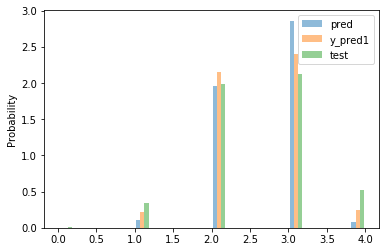

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist([y_pred,y_pred1,y_test], normed=True, bins=20,alpha=0.5,label=['pred','y_pred1','test'])

plt.ylabel('Probability');
plt.legend(loc='upper right')
plt.show()

Plotting metrics recorded during training...


KeyError: ignored

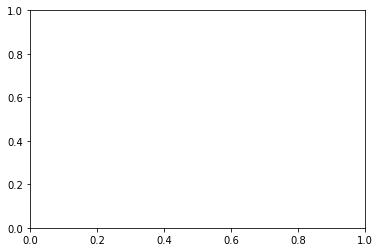

In [0]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

print('Plotting split value histogram...')
ax = lgb.plot_split_value_histogram(gbm, feature='f26', bins='auto')
plt.show()

print('Plotting 54th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(gbm, tree_index=53, figsize=(15, 15), show_info=['split_gain'])
plt.show()

print('Plotting 54th tree with graphviz...')
graph = lgb.create_tree_digraph(gbm, tree_index=53, name='Tree54')
graph.render(view=True)

In [0]:
# from google.colab import files

# uploaded = files.upload()
!ls
#!mv './Aspen Plus Defect Priority Query.csv' 'AES.csv'
#!mv ./*.csv ./gdrive/'My Drive'/data